# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block_16_expand', 'lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8079 - accuracy: 0.7346

947/947 [==============================] - 2481s 3s/step - loss: 0.8079 - accuracy: 0.7346 - val_loss: 3.7366 - val_accuracy: 0.6728
Epoch 2/200
947/947 [==============================] - 2356s 2s/step - loss: 0.6961 - accuracy: 0.7619 - val_loss: 9.9049 - val_accuracy: 0.6661
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.7692

947/947 [==============================] - 2423s 3s/step - loss: 0.6578 - accuracy: 0.7692 - val_loss: 2.0200 - val_accuracy: 0.5995
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7811

947/947 [==============================] - 2390s 3s/step - loss: 0.6287 - accuracy: 0.7811 - val_loss: 1.9874 - val_accuracy: 0.5960
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.7861

947/947 [==============================] - 2376s 3s/step - loss: 0.6085 - accuracy: 0.7861 - val_loss: 1.7033 - val_accuracy: 0.5956
Epoch 6/200
947/947 [==============================] - 2345s 2s/step - loss: 0.5840 - accuracy: 0.7952 - val_loss: 2.9222 - val_accuracy: 0.6743
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7987

947/947 [==============================] - 2354s 2s/step - loss: 0.5707 - accuracy: 0.7987 - val_loss: 0.9535 - val_accuracy: 0.6798
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.8038

947/947 [==============================] - 2341s 2s/step - loss: 0.5539 - accuracy: 0.8038 - val_loss: 0.9193 - val_accuracy: 0.7456
Epoch 9/200
947/947 [==============================] - 2318s 2s/step - loss: 0.5420 - accuracy: 0.8083 - val_loss: 2.5064 - val_accuracy: 0.6702
Epoch 10/200
947/947 [==============================] - 2336s 2s/step - loss: 0.5311 - accuracy: 0.8090 - val_loss: 0.9983 - val_accuracy: 0.7323
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.8135

947/947 [==============================] - 2382s 3s/step - loss: 0.5209 - accuracy: 0.8135 - val_loss: 0.9079 - val_accuracy: 0.7607
Epoch 12/200
947/947 [==============================] - 2312s 2s/step - loss: 0.5071 - accuracy: 0.8211 - val_loss: 1.1865 - val_accuracy: 0.6983
Epoch 13/200
947/947 [==============================] - 2319s 2s/step - loss: 0.4950 - accuracy: 0.8221 - val_loss: 0.9829 - val_accuracy: 0.6547
Epoch 14/200
947/947 [==============================] - 2303s 2s/step - loss: 0.4866 - accuracy: 0.8245 - val_loss: 2.6231 - val_accuracy: 0.5681
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8269

947/947 [==============================] - 2401s 3s/step - loss: 0.4824 - accuracy: 0.8269 - val_loss: 0.6951 - val_accuracy: 0.7774
Epoch 16/200
947/947 [==============================] - 2302s 2s/step - loss: 0.4721 - accuracy: 0.8292 - val_loss: 1.1726 - val_accuracy: 0.7418
Epoch 17/200
947/947 [==============================] - 2295s 2s/step - loss: 0.4641 - accuracy: 0.8326 - val_loss: 0.9784 - val_accuracy: 0.6912
Epoch 18/200
947/947 [==============================] - 2307s 2s/step - loss: 0.4531 - accuracy: 0.8363 - val_loss: 1.2390 - val_accuracy: 0.6616
Epoch 19/200
947/947 [==============================] - 2302s 2s/step - loss: 0.4447 - accuracy: 0.8376 - val_loss: 0.8475 - val_accuracy: 0.7766
Epoch 20/200
947/947 [==============================] - 2306s 2s/step - loss: 0.4356 - accuracy: 0.8429 - val_loss: 0.9419 - val_accuracy: 0.7200
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8455

947/947 [==============================] - 2326s 2s/step - loss: 0.4299 - accuracy: 0.8455 - val_loss: 0.6657 - val_accuracy: 0.7665
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8444

947/947 [==============================] - 2331s 2s/step - loss: 0.4266 - accuracy: 0.8444 - val_loss: 0.6429 - val_accuracy: 0.7814
Epoch 23/200
947/947 [==============================] - 2307s 2s/step - loss: 0.4144 - accuracy: 0.8503 - val_loss: 0.7235 - val_accuracy: 0.7690
Epoch 24/200
947/947 [==============================] - 2312s 2s/step - loss: 0.4076 - accuracy: 0.8527 - val_loss: 0.8001 - val_accuracy: 0.7191
Epoch 25/200
947/947 [==============================] - 2303s 2s/step - loss: 0.4035 - accuracy: 0.8543 - val_loss: 0.9390 - val_accuracy: 0.7255
Epoch 26/200
947/947 [==============================] - 2302s 2s/step - loss: 0.4026 - accuracy: 0.8538 - val_loss: 0.8408 - val_accuracy: 0.7732
Epoch 27/200
947/947 [==============================] - 2300s 2s/step - loss: 0.3921 - accuracy: 0.8584 - val_loss: 0.6630 - val_accuracy: 0.8098
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.8599

947/947 [==============================] - 2328s 2s/step - loss: 0.3856 - accuracy: 0.8599 - val_loss: 0.5541 - val_accuracy: 0.8168
Epoch 29/200
947/947 [==============================] - 2305s 2s/step - loss: 0.3763 - accuracy: 0.8642 - val_loss: 0.5693 - val_accuracy: 0.8114
Epoch 30/200
947/947 [==============================] - 2305s 2s/step - loss: 0.3736 - accuracy: 0.8644 - val_loss: 0.5622 - val_accuracy: 0.8128
Epoch 31/200
947/947 [==============================] - 2311s 2s/step - loss: 0.3718 - accuracy: 0.8652 - val_loss: 0.6846 - val_accuracy: 0.7648
Epoch 32/200
947/947 [==============================] - 2304s 2s/step - loss: 0.3658 - accuracy: 0.8661 - val_loss: 0.7041 - val_accuracy: 0.7818
Epoch 33/200
947/947 [==============================] - 2305s 2s/step - loss: 0.3554 - accuracy: 0.8696 - val_loss: 0.7201 - val_accuracy: 0.7731
Epoch 34/200
947/947 [==============================] - 2302s 2s/step - loss: 0.3518 - accuracy: 0.8722 - val_loss: 0.6449 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 253s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9657829858847053,
 'basal cell carcinoma': 0.9819867314568848,
 'dermatofibroma': 0.9576535656902732,
 'melanoma': 0.9029779858200476,
 'nevus': 0.9531233449406036,
 'pigmented benign keratosis': 0.9802494689843514,
 'seborrheic keratosis': 0.9441843837153263,
 'solar lentigo': 0.9505363089433886,
 'squamous cell carcinoma': 0.9560931088583153,
 'vascular lesion': 0.991975131516021}

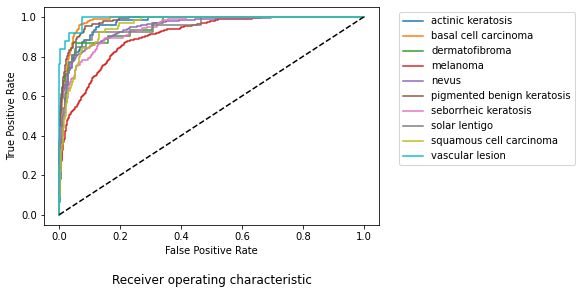

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

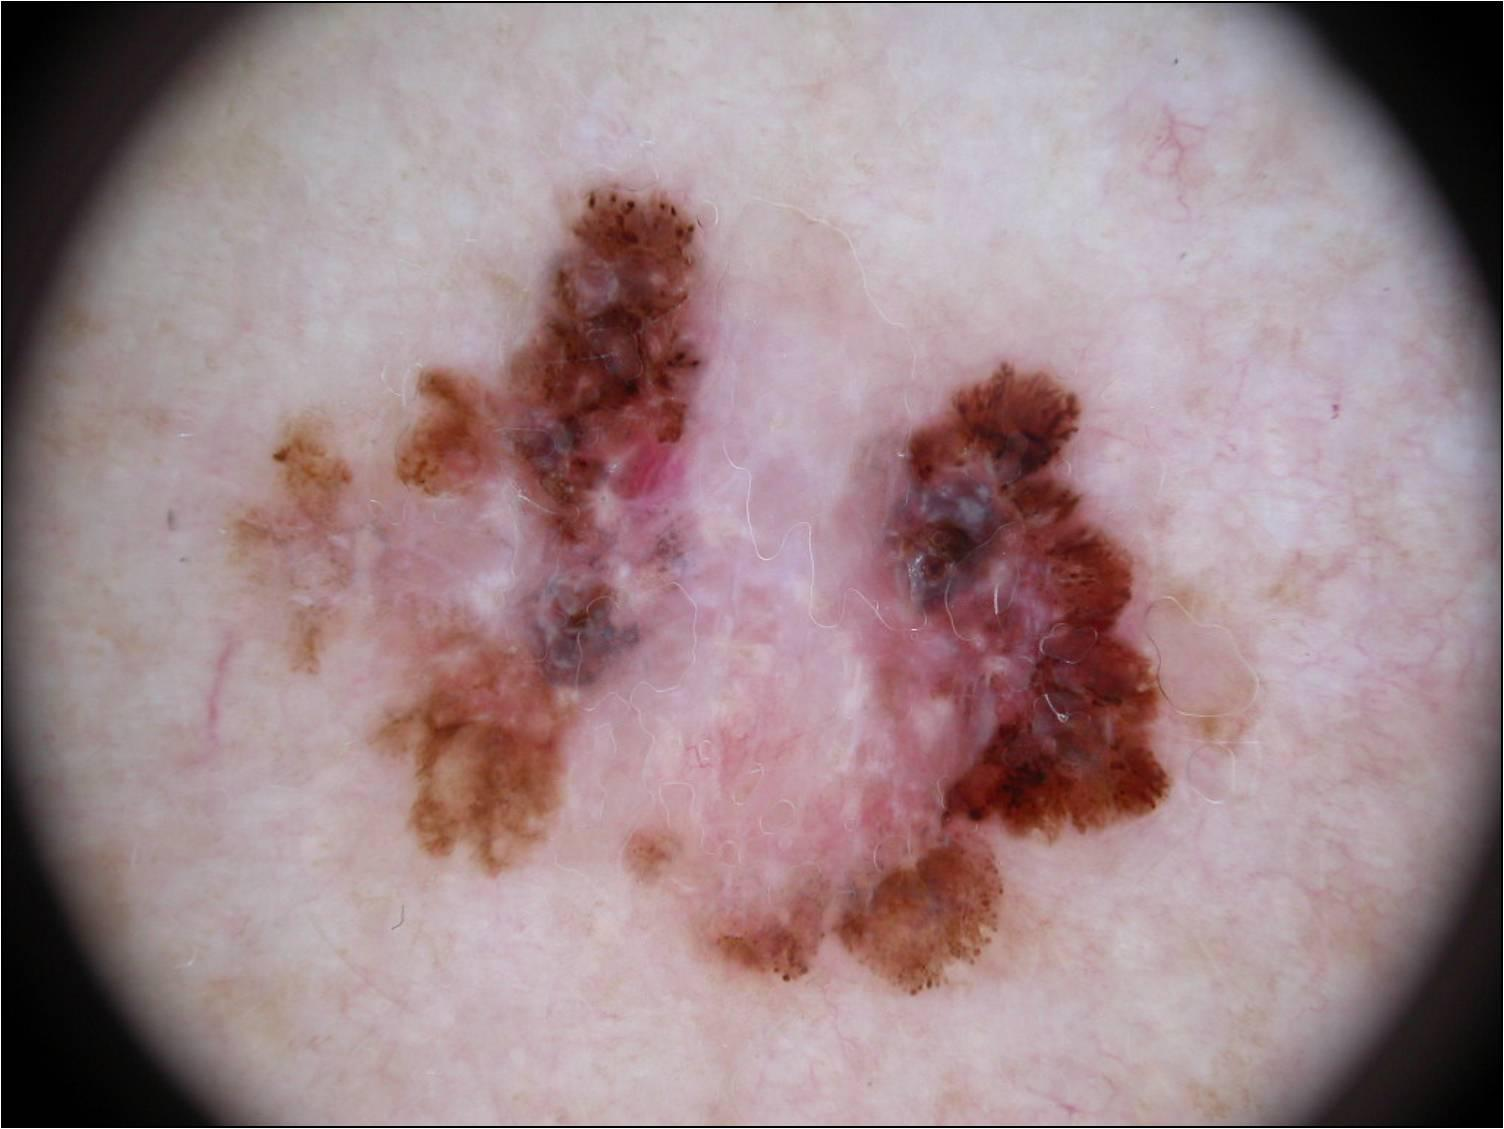

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

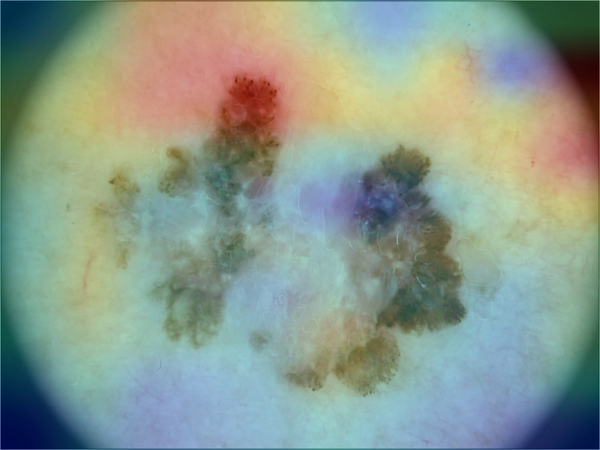

In [23]:
display_gradcam(melanoma_im_path, heatmap)